In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
assets = pd.read_csv("https://storage.googleapis.com/m6-bucket-webapp-public/M6_Universe.csv")
display(assets.head())

df = yf.download(list(assets['symbol'].values))
display(df.head())

,id,class,symbol,name,GICS_sector/ETF_type,GICS_industry/ETF_subtype
0,1,Stock,ABBV,AbbVie,Health Care,Pharmaceuticals
1,2,Stock,ACN,Accenture,Information Technology,IT Consulting & Other Services
2,3,Stock,AEP,American Electric Power,Utilities,Electric Utilities
3,4,Stock,AIZ,Assurant,Financials,Multi-line Insurance
4,5,Stock,ALLE,Allegion,Industrials,Building Products


[*********************100%***********************]  100 of 100 completed


Adj Close                                               ... Volume  \
                ABBV ACN       AEP AIZ ALLE AMAT AMP AMZN AVB AVY  ...    XLC   
Date                                                               ...          
1962-01-02       NaN NaN  1.027577 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-03       NaN NaN  1.025707 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-04       NaN NaN  1.010732 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-05       NaN NaN  0.988271 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-08       NaN NaN  0.980785 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   

                                                       
           XLE XLF XLI XLK XLP XLU XLV XLY        XOM  
Date                                                   
1962-01-02 NaN NaN NaN NaN NaN NaN NaN NaN   902400.0  
1962-01-03 NaN NaN NaN NaN NaN NaN NaN NaN  1200000.0  
1962-01-04 NaN NaN NaN NaN NaN NaN NaN NaN  1088000.0  
1962-01-05 NaN NaN NaN NaN NaN NaN NaN NaN  1222400.0  
1962-01-08 NaN NaN NaN NaN NaN NaN NaN NaN  1388800.0  

[5 rows x 600 columns]

In [46]:
## Group into 20 day returns
"""
Compute Features
"""
X = df.loc["2010-01-01":]['Adj Close']
X = np.log(X).diff(1).iloc[1:]
X = X[X.shape[0] % 20:]
# X = X.rolling(20).sum()
y = X.fillna(0).rolling(20).sum().shift(-21).replace(0, np.nan)
X = pd.concat([X, 
               X.fillna(0).rolling(5).mean().add_suffix("_ma5"), 
               X.fillna(0).rolling(5).std().add_suffix("_sd5"),
               X.fillna(0).rolling(20).mean().add_suffix("_ma20"), 
               X.fillna(0).rolling(20).std().add_suffix("_sd20"),
               X.fillna(0).rolling(50).mean().add_suffix("_ma50"), 
               X.fillna(0).rolling(50).std().add_suffix("_sd50"),
               X.fillna(0).rolling(50).skew().add_suffix("_skew50"), 
               X.fillna(0).rolling(50).kurt().add_suffix("_kurt50"),
               # X.fillna(0).rolling(100).mean().add_suffix("_ma100"), 
               # X.fillna(0).rolling(100).std().add_suffix("_sd100"),
               # X.fillna(0).rolling(250).mean().add_suffix("_ma250"), 
               # X.fillna(0).rolling(250).std().add_suffix("_sd250"),
               # (X.rolling(20).mean().add_suffix("_ma20") / X.rolling(20).std()).add_suffix("_zscore20"),
               # pd.concat([X.mean(axis = 1).shift(i) for i in range(20)], axis = 1).add_prefix(f"cross_sec_ma_lag"),
               # pd.concat([X.std(axis = 1).shift(i) for i in range(20)], axis = 1).add_prefix(f"cross_sec_sd_lag")
              ], axis = 1)
display(X)
## Make y labels
y_labels = y.apply(lambda x: pd.qcut(x, [0, .2, .4, .6, .8, 1.], duplicates='drop',labels=False), axis = 1)
ys = pd.melt(y_labels.reset_index(), id_vars=['Date'])
ys = ys.sort_values(by='Date').reset_index(drop = True)
ys['value'] = ys['value']
display(ys)

,ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,...,XLC_kurt50,XLE_kurt50,XLF_kurt50,XLI_kurt50,XLK_kurt50,XLP_kurt50,XLU_kurt50,XLV_kurt50,XLY_kurt50,XOM_kurt50
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-20,NaN,-0.005501,0.002193,-0.017340,NaN,-0.012244,-0.003811,-0.014444,-0.022630,-0.011547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-21,NaN,-0.009700,-0.011290,0.032470,NaN,-0.016071,-0.027830,0.006656,-0.022766,-0.024276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-22,NaN,-0.021345,-0.019293,0.016791,NaN,-0.072523,-0.024595,-0.041853,-0.024356,-0.001036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,-0.019931,0.024071,0.005701,0.013083,-0.005239,0.032074,0.027090,-0.000316,0.015995,0.013285,...,-0.847128,2.092886,-0.181009,0.403148,-0.772081,8.941815,0.414197,0.132818,-0.031141,2.289977
2022-05-24,0.007269,-0.014502,0.019261,0.012582,-0.004619,-0.030854,-0.009204,-0.032669,0.004008,-0.023489,...,-0.923075,2.560085,-0.098367,0.409620,-0.751899,8.581513,0.269938,0.138338,-0.102366,2.954768
2022-05-25,0.018933,0.001181,0.002540,0.002873,0.000833,0.020479,0.017571,0.025372,-0.000341,0.015358,...,-0.898225,3.216798,-0.037897,0.524103,-0.692479,9.328539,0.361852,0.220545,-0.088738,3.961942


,Date,variable,value
0,2010-01-18,ABBV,NaN
1,2010-01-18,PPL,1.0
2,2010-01-18,IUMO.L,NaN
3,2010-01-18,AIZ,4.0
4,2010-01-18,IEF,4.0
...,...,...,...
317995,2022-05-27,OGN,NaN
317996,2022-05-27,PG,NaN
317997,2022-05-27,PPL,NaN
317998,2022-05-27,PYPL,NaN


In [49]:
"""
Make Datafrmae
"""
data = pd.merge(X, ys, on = 'Date')
data = data[data.count(axis = 1) > 10].reset_index(drop = True)
data['variable'] = data['variable']
data['asset'] = data['variable'].astype("category")
data = data.set_index(['Date', 'variable'])
# data = pd.merge(data, assets[['GICS_sector/ETF_type', 'GICS_industry/ETF_subtype', 'symbol']], left_on=['asset'], right_on=['symbol'])
# data = data.drop('symbol', axis = 1)
# data[['asset','GICS_sector/ETF_type','GICS_industry/ETF_subtype']] = data[['asset','GICS_sector/ETF_type','GICS_industry/ETF_subtype']].astype("category")
display(data)

"""
Drop missing rows
"""
X, y = data.loc[~data['value'].isna()].drop('value', axis = 1), data['value'].dropna()
y = y.astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=False)
lgb_data = lgb.Dataset(X_train, y_train)
val_data = lgb.Dataset(X_val, y_val)
print(X_train.shape, X_val.shape)

SyntaxError: EOF while scanning triple-quoted string literal (2283775872.py, line 20)

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 228202
[LightGBM] [Info] Number of data points in the train set: 267152, number of used features: 901


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score -1.589966
[LightGBM] [Info] Start training from score -1.621269
[LightGBM] [Info] Start training from score -1.616658
[LightGBM] [Info] Start training from score -1.621344
[LightGBM] [Info] Start training from score -1.598371
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 1.52093	valid_0's multi_logloss: 1.57451


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

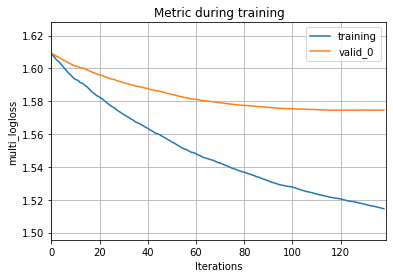

In [5]:
params = {"objective":"multiclass", 
          "num_boost_round":300, 
          "metric": ["multi_logloss"], # 'None'
          "num_classes":5,
          "first_metric_only": True,
          "feature_pre_filter": True,
          "learning_rate":0.01,
          "num_leaves":16,
          "bagging_fraction": 0.8,
          "feature_fraction": 0.8,
          "force_row_wise":True}

def RPS_metric(preds, eval_data):
    """
    Custom Metric to use the RPS
    """
    true = eval_data.get_label()
    preds = preds.T.reshape((5, -1)).T
    value =  np.mean((pd.get_dummies(true).cumsum(axis = 1) - np.cumsum(preds.reshape((-1, 5)), axis = 1)) ** 2, axis = 1).mean()
    return "RPS", value, False

res_dict = {}
booster = lgb.train(params, 
                    lgb_data, 
                   valid_sets= (val_data, lgb_data),
                   # feval = RPS_metric,
                   callbacks=[lgb.record_evaluation(res_dict), 
                              lgb.early_stopping(20)])

lgb.plot_metric(res_dict)

In [6]:
def diagnosis(y, pred):
    RPS = np.mean((pd.get_dummies(y).cumsum(axis = 1) - np.cumsum(pred, axis = 1)) ** 2, axis = 1).mean()
    return RPS
res = [{"index":"baseline", "train":diagnosis(y_train, np.ones((y_train.shape[0], 5)) / 5),
       "val":diagnosis(y_val, np.ones((y_val.shape[0], 5)) / 5)}]

In [7]:
pred_train = booster.predict(X_train)
pred_val = booster.predict(X_val)

In [31]:
pred_val = booster.predict(X_val)

In [17]:
perf_per_var_time = np.mean((pd.get_dummies(y_train).cumsum(axis = 1).reset_index().set_index(['variable','Date']) - np.cumsum(pred_train, axis = 1)) ** 2, axis = 1)
perf_per_var = pd.pivot(perf_per_var_time.reset_index(), index=['Date'], columns=['variable'])
perf_per_var.ewm(alpha=0.85).mean().iloc[-1].plot()

<AxesSubplot:xlabel='None,variable'>

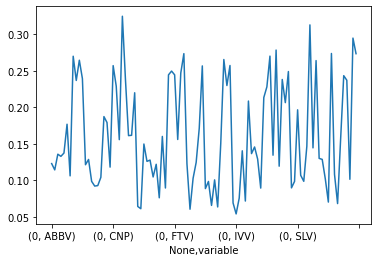

In [34]:
perf_per_var_time_val = np.mean((pd.get_dummies(y_val).cumsum(axis = 1).reset_index().set_index(['variable','Date']) - np.cumsum(pred_val, axis = 1)) ** 2, axis = 1)
perf_per_var_val = pd.pivot(perf_per_var_time_val.reset_index(), index=['Date'], columns=['variable'])
perf_per_var_val.ewm(alpha=0.85).mean().iloc[-1].plot()

In [36]:
perf_per_var_val.mean().sort_values()

   variable
0  IVV         0.086835
   SPMV.L      0.089573
   HIGH.L      0.092354
   XLI         0.096182
   HYG         0.099071
                 ...   
   VXX         0.211103
   GSG         0.221210
   PYPL        0.232802
   CZR         0.240916
   CARR        0.248858
Length: 100, dtype: float64

In [43]:
data

ABBV       ACN       AEP       AIZ     ALLE  \
Date       variable                                                    
2010-01-20 DG             NaN -0.005501  0.002193 -0.017340      NaN   
           PRU            NaN -0.005501  0.002193 -0.017340      NaN   
           EWH            NaN -0.005501  0.002193 -0.017340      NaN   
           XLE            NaN -0.005501  0.002193 -0.017340      NaN   
           IEF            NaN -0.005501  0.002193 -0.017340      NaN   
...                       ...       ...       ...       ...      ...   
2022-04-28 EWL      -0.008346  0.034820  0.028721  0.001075  0.02704   
           EWJ      -0.008346  0.034820  0.028721  0.001075  0.02704   
           EWH      -0.008346  0.034820  0.028721  0.001075  0.02704   
           XLB      -0.008346  0.034820  0.028721  0.001075  0.02704   
           XOM      -0.008346  0.034820  0.028721  0.001075  0.02704   

                         AMAT       AMP      AMZN      AVB       AVY  ...  \
Date       variable                                                   ...   
2010-01-20 DG       -0.012244 -0.003811 -0.014444 -0.02263 -0.011547  ...   
           PRU      -0.012244 -0.003811 -0.014444 -0.02263 -0.011547  ...   
           EWH      -0.012244 -0.003811 -0.014444 -0.02263 -0.011547  ...   
           XLE      -0.012244 -0.003811 -0.014444 -0.02263 -0.011547  ...   
           IEF      -0.012244 -0.003811 -0.014444 -0.02263 -0.011547  ...   
...                       ...       ...       ...      ...       ...  ...   
2022-04-28 EWL       0.052106  0.024857  0.045484 -0.00533  0.012278  ...   
           EWJ       0.052106  0.024857  0.045484 -0.00533  0.012278  ...   
           EWH       0.052106  0.024857  0.045484 -0.00533  0.012278  ...   
           XLB       0.052106  0.024857  0.045484 -0.00533  0.012278  ...   
           XOM       0.052106  0.024857  0.045484 -0.00533  0.012278  ...   

                     XLF_kurt50  XLI_kurt50  XLK_kurt50  XLP_kurt50  \
Date       variable                                                   
2010-01-20 DG               NaN         NaN         NaN         NaN   
           PRU              NaN         NaN         NaN         NaN   
           EWH              NaN         NaN         NaN         NaN   
           XLE              NaN         NaN         NaN         NaN   
           IEF              NaN         NaN         NaN         NaN   
...                         ...         ...         ...         ...   
2022-04-28 EWL         0.215041   -0.170265   -0.874918    0.904763   
           EWJ         0.215041   -0.170265   -0.874918    0.904763   
           EWH         0.215041   -0.170265   -0.874918    0.904763   
           XLB         0.215041   -0.170265   -0.874918    0.904763   
           XOM         0.215041   -0.170265   -0.874918    0.904763   

                     XLU_kurt50  XLV_kurt50  XLY_kurt50  XOM_kurt50  value  \
Date       variable                                                          
2010-01-20 DG               NaN         NaN         NaN         NaN      1   
           PRU              NaN         NaN         NaN         NaN      1   
           EWH              NaN         NaN         NaN         NaN      3   
           XLE              NaN         NaN         NaN         NaN      2   
           IEF              NaN         NaN         NaN         NaN      3   
...                         ...         ...         ...         ...    ...   
2022-04-28 EWL         0.108666    0.467256   -0.406607    0.912427      1   
           EWJ         0.108666    0.467256   -0.406607    0.912427      3   
           EWH         0.108666    0.467256   -0.406607    0.912427      3   
           XLB         0.108666    0.467256   -0.406607    0.912427      3   
           XOM         0.108666    0.467256   -0.406607    0.912427      4   

                     asset  
Date       variable         
2010-01-20 DG           DG  
           PRU         PRU  
           EWH         EWH  
  

In [77]:
pred_set = set(perf_per_var_val.mean().loc[perf_per_var_val.mean() <= 0.16].reset_index()['variable'])

In [64]:
X_test = data.loc['2022-05-27'].drop('value', axis = 1)
pred_test = booster.predict(X_test)
my_submission = pd.DataFrame(pred_test, index = X_test.index, columns=[f"Rank{i}" for i in range(1, 6)]).reset_index()

In [71]:
# my_submission = my_submission.drop('Date', axis = 1)
my_submission = my_submission.rename({"variable": "ID"}, axis = 1)

In [110]:
data.iloc[-5000:, :100].mean().idxmin()

'CZR'

In [95]:
my_submission.loc[~my_submission['ID'].isin(pred_set), [f"Rank{i}" for i in range(1, 6)]] = 0.2
my_submission['Decision'] = 0.01

In [96]:
len(pred_set)

48

In [127]:
from numpy.random import default_rng
my_submission.iloc[:, 1:] = my_submission.iloc[:, 1:].astype(np.float32)
err = my_submission.iloc[:, 1:6].sum(axis = 1) - 1
rng = default_rng(42)
col = rng.choice(5, 100)
for i in range(100):
    my_submission.iloc[i, 1 + col[i]] -= err.iloc[i]
my_submission.iloc[:, 1:6] = my_submission.iloc[:, 1:6].round(5)

In [128]:
my_submission.to_csv("submission.csv", index=False)

<AxesSubplot:>

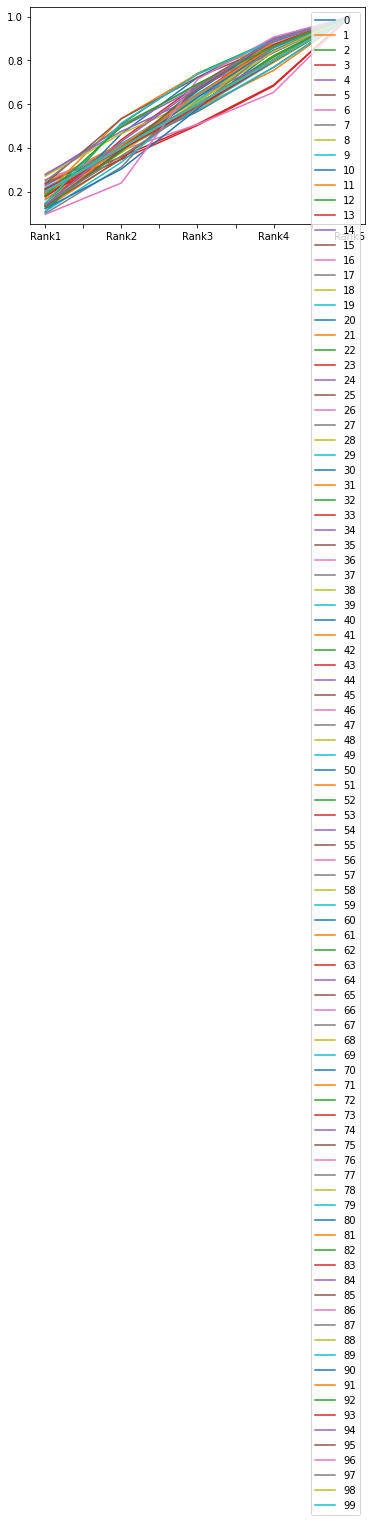

In [135]:
my_submission.iloc[:, 1:6].cumsum(axis = 1).T.plot()